In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA, PCA
from sklearn import linear_model

# Proteome Binning Analysis

Here we consider the proteome in even-width bins of protein $Z_C$. That is: we group proteins by their $Z_C$ values and then ask which bins of proteins go up or down in total C content as the growth rate $\mu$ changes.

Given $Z_C$ is defined as a C-weighted average of C oxidation states, for proteome $Z_{C,P}$ to decrease with growth rate it must be the case that relatively reduced bins (with lower $Z_C$) grow more in C content than relatively oxidized ones. Otherwise the primary observation would not be possible. Nonetheless, the changes could be localized to a small number of proteins and therefore a small number of $Z_C$ bins, or they could be spread throughout the proteome. The latter case is what we would predict from our model, since the model does not "care" which proteins accumulate reduced amino acids so long as their expression is correlated with growth. 

Analysis of the binned data indeed documents that changes are spread throughout the proteome.

In [2]:
# Read in a combined dataframe of all the coding sequence NOSC values.
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')
coli_nosc_df = pd.read_csv('../data/genomes/Coli/MG1655/MG1655_ref_prot_NOSC.csv').set_index('b_number')

# Read in whole proteome NOSC data per-organism
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

all_data_df = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


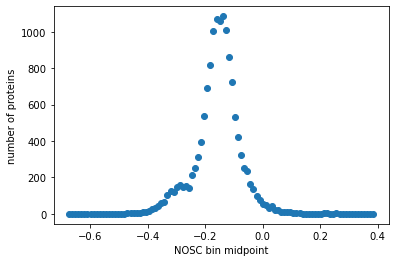

In [3]:
# Bin all the proteins by NOSC
binned, nosc_bins = pd.cut(long_nosc_df.NOSC, 100, retbins=True)
bin_counts = long_nosc_df.groupby(binned).count()['gene_name']
midpoints = [np.mean([i.left, i.right]) for i in bin_counts.index]
plt.scatter(midpoints, bin_counts)
plt.xlabel('NOSC bin midpoint')
plt.ylabel('number of proteins')
plt.show()

0 PCC6803
1 coli
2 yeast


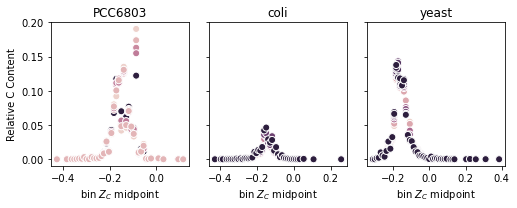

In [4]:
# Subset of the data that is chemostats
mask = np.logical_and(
    all_data_df.dataset == 'schmidt_2016',
    all_data_df.condition.str.startswith('chemo'))
mask = np.logical_or(mask,
                     all_data_df.organism_key.isin('yeast,PCC6803'.split(',')))
chemostat_data_df = all_data_df[mask]

# make the figure as we go.
fig, axs = plt.subplots(ncols=3, figsize=(7.22, 3), sharey=True)
flat_axs = axs.flatten()
agg_dict = dict(rel_C='sum', dataset='first', Ce_total='sum', NC_per='sum',
                NC_total='sum', NOSC='mean')
binned_dfs = []
working_dfs = []
for idx, (gid, gdf) in enumerate(chemostat_data_df.groupby('organism_key')):
    print(idx, gid)
    
    # Make a copy for working, no proteins without known NOSC
    masked_gdf = gdf[gdf.NOSC.notnull()].copy()
    
    # Sum the total measured mass per condition.
    mass_totals = masked_gdf.groupby('condition').sum()['fg_per_cell']
    C_totals = masked_gdf.groupby('condition').sum()['NC_total']
    per_entry_mass_total = mass_totals.loc[masked_gdf.condition].values
    per_entry_C_total = C_totals.loc[masked_gdf.condition].values

    # Calculate the relative C, i.e. the fraction of measured C atoms associated with this protein.
    rel_C = masked_gdf.NC_total / per_entry_C_total

    # put bins in there
    my_bins = pd.cut(masked_gdf.NOSC, nosc_bins)
    NOSC_bin_midpoints = [np.mean([b.left, b.right]) for b in my_bins.values]
    
    # Add derived data to working DF
    masked_gdf['NOSC_bin_midpoint'] = NOSC_bin_midpoints
    masked_gdf['rel_C'] = rel_C
    masked_gdf['organism_key'] = gid
    working_dfs.append(masked_gdf)
    
    grp_cols = 'condition,growth_rate_hr,NOSC_bin_midpoint,organism_key'.split(',')
    tmp = masked_gdf.groupby(grp_cols).agg(agg_dict).reset_index()
    binned_dfs.append(tmp)
    
    plt.sca(flat_axs[idx])
    sns.scatterplot(data=tmp, x='NOSC_bin_midpoint', y='rel_C', hue='growth_rate_hr', 
                    edgecolors='w', linewidth=1, s=50, legend=False, hue_norm=LogNorm())
    plt.title(gid)
    plt.xlabel('bin $Z_C$ midpoint')
    if idx == 0:
        plt.ylabel('Relative C Content')

plt.tight_layout()

In [5]:
all_bins = pd.concat(binned_dfs)
all_working_dfs = pd.concat(working_dfs)
all_bins

,condition,growth_rate_hr,NOSC_bin_midpoint,organism_key,rel_C,dataset,Ce_total,NC_per,NC_total,NOSC
0,photobio_1100_uE,0.930,-0.4275,PCC6803,0.000001,zavrel_2019,-8.062655e+00,526.0,1.877859e+01,-0.429354
1,photobio_1100_uE,0.930,-0.3845,PCC6803,0.000062,zavrel_2019,-3.062025e+02,3006.0,7.874683e+02,-0.389377
2,photobio_1100_uE,0.930,-0.3635,PCC6803,0.000206,zavrel_2019,-9.547636e+02,3290.0,2.641713e+03,-0.361634
3,photobio_1100_uE,0.930,-0.3525,PCC6803,0.000096,zavrel_2019,-4.377761e+02,1508.0,1.234140e+03,-0.354721
4,photobio_1100_uE,0.930,-0.3420,PCC6803,0.000409,zavrel_2019,-1.796626e+03,2931.0,5.231818e+03,-0.343423
...,...,...,...,...,...,...,...,...,...,...
418,chemostat_u0.379,0.379,0.2035,yeast,0.000079,xia_2022,5.702524e+06,2568.0,2.827807e+07,0.201659
419,chemostat_u0.379,0.379,0.2245,yeast,0.000392,xia_2022,3.184860e+07,5226.0,1.395976e+08,0.228146
420,chemostat_u0.379,0.379,0.2565,yeast,0.000000,xia_2022,0.000000e+00,2346.0,0.000000e+00,0.253517
421,chemostat_u0.379,0.379,0.3105,yeast,0.000149,xia_2022,1.651876e+07,4749.0,5.320283e+07,0.310486


0 PCC6803
1 coli
2 yeast


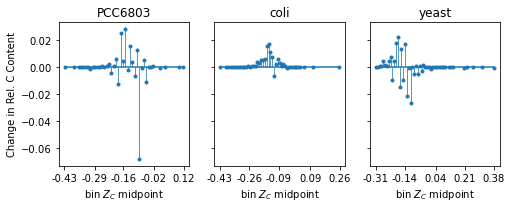

In [6]:
# make the figure as we go.
fig, axs = plt.subplots(ncols=3, figsize=(7.22, 3), sharey=True)
flat_axs = axs.flatten()
epsilon = 1e-4

diff_dfs = []
for idx, (gid, binned) in enumerate(all_bins.groupby('organism_key')):
    print(idx, gid)
    min_mu = binned.growth_rate_hr.min()
    max_mu = binned.growth_rate_hr.max()
    
    min_bins = binned[binned.growth_rate_hr == min_mu]
    max_bins = binned[binned.growth_rate_hr == max_mu]
    
    # Calculate the change in relative C content and the
    # relative change in relative C content!
    dC = max_bins.rel_C.values - min_bins.rel_C.values
    denom = max_bins.rel_C.values
    denom[max_bins.rel_C.isnull()] = epsilon
    denom[max_bins.rel_C == 0] = epsilon
    rel_dC = dC / denom
    
    diffs = min_bins.copy().rename(columns=dict(rel_C='rel_C_min_growth_rate'))
    diffs['rel_C_max_growth_rate'] = max_bins.rel_C.values
    diffs['max_growth_rate_hr'] = max_mu
    diffs['min_growth_rate_hr'] = min_mu
    diffs['drel_C'] = dC
    diffs['rel_drel_C'] = rel_dC
    diff_dfs.append(diffs)
    
    plt.sca(flat_axs[idx])
    plt.title(gid)
    #plt.yscale('symlog', linthresh=0.01)
    
    markerline, stemline, baseline = plt.stem(
        diffs.NOSC_bin_midpoint, diffs.drel_C, basefmt='')    
    plt.setp(stemline, linewidth=0.75)
    plt.setp(markerline, markersize=3)

    xmin = diffs.NOSC_bin_midpoint.min()
    xmax = diffs.NOSC_bin_midpoint.max()  
    xs = np.round(np.linspace(xmin, xmax, 5), 2)
    plt.xticks(xs, xs)
    plt.xlabel('bin $Z_C$ midpoint')
    if idx == 0:
        plt.ylabel('Change in Rel. C Content')
        
plt.tight_layout()
plt.savefig('../output/proteome_bins.png', facecolor='w', dpi=600)
plt.show()

In [7]:
all_diffs = pd.concat(diff_dfs)
all_diffs.head()

,condition,growth_rate_hr,NOSC_bin_midpoint,organism_key,rel_C_min_growth_rate,dataset,Ce_total,NC_per,NC_total,NOSC,rel_C_max_growth_rate,max_growth_rate_hr,min_growth_rate_hr,drel_C,rel_drel_C
117,photobio_27.5_uE,0.025,-0.4275,PCC6803,0.000001,zavrel_2019,-7.918592,526.0,18.443054,-0.429354,0.000001,0.93,0.025,3.436876e-07,0.234320
118,photobio_27.5_uE,0.025,-0.3845,PCC6803,0.000073,zavrel_2019,-465.631395,3006.0,1197.328910,-0.389377,0.000062,0.93,0.025,-1.140214e-05,-0.185380
119,photobio_27.5_uE,0.025,-0.3635,PCC6803,0.000180,zavrel_2019,-1067.703940,3290.0,2952.258637,-0.361634,0.000206,0.93,0.025,2.656456e-05,0.128744
120,photobio_27.5_uE,0.025,-0.3525,PCC6803,0.000081,zavrel_2019,-469.790922,1508.0,1324.393762,-0.354721,0.000096,0.93,0.025,1.574876e-05,0.163377
121,photobio_27.5_uE,0.025,-0.3420,PCC6803,0.000314,zavrel_2019,-1772.241770,2931.0,5160.829970,-0.343423,0.000409,0.93,0.025,9.438352e-05,0.230969


In [8]:

def safe_pearsonr(a, b):
    if len(a) < 2 or len(b) < 2:
        return np.NaN, np.NaN
    return pearsonr(a,b)
mask = np.logical_and(all_working_dfs.rel_C.notnull(), 
                      all_working_dfs.growth_rate_hr.notnull())
my_working_data = all_working_dfs[mask]
tmp = my_working_data.groupby('majority_protein_ids,organism_key,species,strain,dataset'.split(',')).apply(
    lambda x: safe_pearsonr(x.rel_C, x.growth_rate_hr))
gr_corr = pd.DataFrame(tmp.tolist(), columns='R,P'.split(','), index=tmp.index)
gr_corr['P_corrected'] = gr_corr.P * gr_corr.P.size

agg_dict = dict(rel_C='max')
tmp = my_working_data.groupby('majority_protein_ids,organism_key,species,strain,dataset'.split(',')).agg(agg_dict)
gr_corr['max_rel_C'] = tmp.rel_C.values
gr_corr['max_rel_C_pct'] = tmp.rel_C.values*100

/opt/miniconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [9]:
mask = np.logical_and(gr_corr.R < -0.70, gr_corr.max_rel_C > 1e-4)
neg_correlations = gr_corr[mask].sort_values('R')
neg_correlations['sign'] = '-'

mask = np.logical_and(np.abs(gr_corr.R) <= 0.70, gr_corr.max_rel_C > 1e-4) 
weaker_correlations = gr_corr[mask].sort_values('R')
weaker_correlations['sign'] = '~'

mask = np.logical_and(gr_corr.R > 0.70, gr_corr.max_rel_C > 1e-4)
pos_correlations = gr_corr[mask].sort_values('R', ascending=False)
pos_correlations['sign'] = '+'
high_corr_genes = pd.concat([pos_correlations, weaker_correlations, neg_correlations])
high_corr_genes.head()

,,,,,R,P,P_corrected,max_rel_C,max_rel_C_pct,sign
majority_protein_ids,organism_key,species,strain,dataset,,,,,,
P69786,coli,E. coli,BW25113,schmidt_2016,0.999999,0.000001,0.009752,0.001083,0.108336,+
P0A912,coli,E. coli,BW25113,schmidt_2016,0.999989,0.000011,0.074342,0.000744,0.074423,+
P0A855,coli,E. coli,BW25113,schmidt_2016,0.999861,0.000139,0.906781,0.000134,0.013371,+
P0AGE9,coli,E. coli,BW25113,schmidt_2016,0.999817,0.000183,1.197630,0.001003,0.100338,+
P0ACG1,coli,E. coli,BW25113,schmidt_2016,0.999757,0.000243,1.591404,0.000101,0.010149,+


PCC6803
pos N = 324, <Z_C> = -0.1469
neg N = 47, <Z_C> = -0.1647
weak N = 318, <Z_C> = -0.1637
-0.01776178870029549
-0.016764144748386417
coli
pos N = 357, <Z_C> = -0.1422
neg N = 65, <Z_C> = -0.1453
weak N = 33, <Z_C> = -0.1588
-0.0030752397070817616
-0.016619196661829955
yeast
pos N = 268, <Z_C> = -0.1463
neg N = 166, <Z_C> = -0.1379
weak N = 232, <Z_C> = -0.1516
0.008387187647738714
-0.005296432062885936


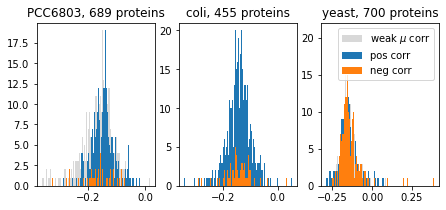

In [10]:
fig, axs = plt.subplots(ncols=3, figsize=(7.22,3))
pal = sns.color_palette()
my_nosc_df = long_nosc_df.set_index('primary_accession')

for idx, (gid, gdf) in enumerate(high_corr_genes.reset_index().groupby('organism_key')):
    print(gid)
    plt.sca(axs[idx])
    plt.title('{0}, {1} proteins'.format(gid, gdf.majority_protein_ids.size))
    pos_ids = set(gdf[gdf.sign == '+'].majority_protein_ids).intersection(
        my_nosc_df.index.values)
    neg_ids = set(gdf[gdf.sign == '-'].majority_protein_ids).intersection(
        my_nosc_df.index.values)
    weak_ids = set(gdf[gdf.sign == '~'].majority_protein_ids).intersection(
        my_nosc_df.index.values)
    
    pos_noscs = my_nosc_df.loc[pos_ids].NOSC.values
    weak_noscs = my_nosc_df.loc[weak_ids].NOSC.values
    neg_noscs = my_nosc_df.loc[neg_ids].NOSC.values

    plt.hist(weak_noscs, color='grey', bins=100, label='weak $\mu$ corr', alpha=0.3)
    plt.hist(pos_noscs, color=pal[0], bins=100, label='pos corr')
    plt.hist(neg_noscs, color=pal[1], bins=100, label='neg corr')
        
    pos_nosc_mean = np.nanmean(pos_noscs)
    neg_nosc_mean = np.nanmean(neg_noscs)
    weak_nosc_mean = np.nanmean(weak_noscs)
    print('pos N = {0}, <Z_C> = {1:.4f}'.format(pos_noscs.size, pos_nosc_mean))
    print('neg N = {0}, <Z_C> = {1:.4f}'.format(neg_noscs.size, neg_nosc_mean))
    print('weak N = {0}, <Z_C> = {1:.4f}'.format(weak_noscs.size, weak_nosc_mean))

    #plt.axvline(pos_nosc_mean, color=pal[0], ls='--')
    #plt.axvline(neg_nosc_mean, color=pal[1], ls='--')
    print(neg_nosc_mean - pos_nosc_mean)
    print(weak_nosc_mean - pos_nosc_mean)

plt.legend()
plt.show()

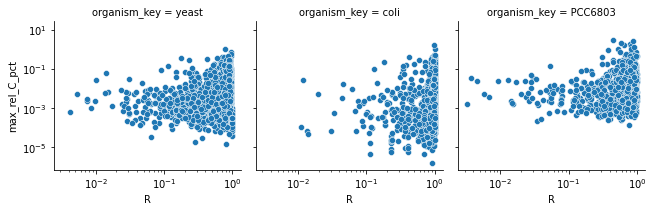

In [11]:
g = sns.FacetGrid(data=gr_corr.reset_index(), col="organism_key", sharey=True)
g.map(sns.scatterplot, "R", "max_rel_C_pct").set(yscale='log').set(xscale='log')